#### Import block

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant

from sklearn.utils import class_weight

%matplotlib inline

In [2]:
# Check for available GPU.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Function definitions

In [3]:
# Loader functions
# Inspiration: https://towardsdatascience.com/writing-custom-keras-generators-fe815d992c5a

def get_input(path):
    # Load array.
    t_input = np.load(path)
    # Pad to even number of pixels
    t_input = np.pad(t_input, [(0,0),(0,1),(0,1)])
    # Resize to include a channel dimension.
    t_input = tf.expand_dims(t_input, axis = -1)
    return t_input

def get_output(path):
    # Load array.
    t_output = np.load(path)
    # Pad to even number of pixels
    t_output = np.pad(t_output, [(0,0),(0,1),(0,1)])
    # Resize to include a channel dimension.
    t_output = tf.expand_dims(t_output, axis = -1)
    return t_output

def data_generator(samples, batch_size = 64):
    
    while True:
        # Select files (paths/indices) for the batch
        batch_samples  = np.random.choice(a = samples.index, 
                                      size = batch_size)
        batch_input  = []
        batch_output = [] 

        # Read in each input, perform preprocessing and get labels
        for sample in batch_samples:
          input = get_input(samples.loc[sample].features)
          output = get_output(samples.loc[sample].labels)

          batch_input += [input]
          batch_output += [output]
        # Return a tuple of (input, output) to feed the network
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)
        
        yield(batch_x, batch_y)


In [4]:
m = pd.read_csv('Sample_CLSTM_Dataset/train/meta.csv')
m

,Unnamed: 0,Lon,Lat,Date,features,labels
0,424178,-53.777985,-6.178985,2018-09-16,Sample_CLSTM_Dataset/train/features/424178.npy,Sample_CLSTM_Dataset/train/labels/424178.npy
1,211198,-51.735630,-8.470318,2017-09-26,Sample_CLSTM_Dataset/train/features/211198.npy,Sample_CLSTM_Dataset/train/labels/211198.npy
2,197713,-50.511791,-9.797287,2017-09-20,Sample_CLSTM_Dataset/train/features/197713.npy,Sample_CLSTM_Dataset/train/labels/197713.npy
3,610851,-50.733681,-9.001179,2019-09-02,Sample_CLSTM_Dataset/train/features/610851.npy,Sample_CLSTM_Dataset/train/labels/610851.npy
4,164188,-57.372284,-6.126301,2017-09-14,Sample_CLSTM_Dataset/train/features/164188.npy,Sample_CLSTM_Dataset/train/labels/164188.npy
...,...,...,...,...,...,...
9889,152245,-50.735508,-7.020069,2017-09-13,Sample_CLSTM_Dataset/train/features/152245.npy,Sample_CLSTM_Dataset/train/labels/152245.npy
9890,423700,-51.096798,-6.575891,2018-09-16,Sample_CLSTM_Dataset/train/features/423700.npy,Sample_CLSTM_Dataset/train/labels/423700.npy
9891,190811,-56.483700,-7.026057,2017-09-19,Sample_CLSTM_Dataset/train/features/190811.npy,Sample_CLSTM_Dataset/train/labels/190811.npy
9892,135776,-51.519547,-9.694668,2017-09-10,Sample_CLSTM_Dataset/train/features/135776.npy,Sample_CLSTM_Dataset/train/labels/135776.npy


#### Load data

In [5]:
# Get data from one chip
sample_input = np.load('Sample_CLSTM_Dataset/train/features/119179.npy')

# Pad to even number of pixels
#a = np.pad(sample_input, [(0,0),(0,1),(0,1)])
# Resize to include a channel dimension.
#a = tf.expand_dims(a, axis = -1)
# Resize to include a batch dimension.
#a = tf.expand_dims(a, axis = 0)


# Move channel axis to the end
a = np.moveaxis(sample_input, 1, -1)

# Limit channel dim to fire pixels only.
a = a[:,:,:,:1]

# Resize to include a batch dimension.
a = tf.expand_dims(a, axis = 0)

# Display shape for verification.
a.shape

TensorShape([1, 10, 32, 32, 1])

#### Model assumbly

In [6]:
# Inspired by: https://keras.io/examples/vision/conv_lstm/?fbclid=IwAR1QSJmF0bcz5pklHDHwl4mUi8inzHN4m8Zk6OpvVJizqDDv2-MKMq3LlJ8

inputs = layers.Input(shape=((10,32,32,1)))
x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    padding='same',
    return_sequences=False,
    activation='relu',
)(inputs)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=False,
    activation='relu',
)(tf.expand_dims(x, axis = 1))
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(1, 1),
    padding='same',
    return_sequences=False,
    activation='relu',
)(tf.expand_dims(x, axis = 1))
outputs = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation='sigmoid', padding='same'
)(tf.expand_dims(x, axis = 1))

In [7]:
forecast_model = tf.keras.Model(inputs, outputs, name="Conv_LSTM")

In [8]:
# Verify output shape.
forecast_model.predict(a).shape

1/1 [==============================] - 2s 2s/step


(1, 1, 32, 32, 1)

In [9]:
# Display model details.
forecast_model.summary()

Model: "Conv_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 32, 32, 1)]   0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 32, 32, 128)       1651712   
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 1, 32, 32, 128)   0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 32, 32, 128)       1180160   
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                         

In [10]:
# Compile model.
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
forecast_model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])

In [11]:
# Data loaders.
batch_size = 64
meta_t = pd.read_csv('Sample_CLSTM_Dataset/train/meta.csv')
meta_v = pd.read_csv('Sample_CLSTM_Dataset/val/meta.csv')
t_gen = data_generator(meta_t, batch_size = batch_size)
v_gen = data_generator(meta_v, batch_size = batch_size)

In [12]:
# Trying new approach to build dataset.
x_train, y_train, x_val, y_val = [],[],[],[]

# Iterate over dataset.
for x in range(0,len(meta_t)):
    x_train.append(np.load(meta_t.iloc[x].features))
    y_train.append(np.load(meta_t.iloc[x].labels))
for x in range(0,len(meta_v)):
    x_val.append(np.load(meta_v.iloc[x].features))
    y_val.append(np.load(meta_v.iloc[x].labels))
    
# Stack layers.
x_train = np.stack(x_train)
y_train = np.stack(y_train)
x_val = np.stack(x_val)
y_val = np.stack(y_val)

# Move channel dims to last.
x_train = np.moveaxis(x_train, 2, -1)
y_train = tf.expand_dims(y_train, axis = -1).numpy()
x_val = np.moveaxis(x_val, 2, -1)
y_val = tf.expand_dims(y_val, axis = -1).numpy()

# Limit channel dim to fire pixels only.
x_train = x_train[:,:,:,:,:1]
x_val = x_val[:,:,:,:,:1]

# Convert values > 1 to 1.
x_train = np.minimum(x_train,1)
y_train = np.minimum(y_train,1)
x_val = np.minimum(x_val,1)
y_val = np.minimum(y_val,1)

## Pad to even shape.
#x_train = np.pad(x_train, [(0,0),(0,0),(0,1),(0,1)])
#y_train = np.pad(y_train, [(0,0),(0,0),(0,1),(0,1)])
#x_val = np.pad(x_val, [(0,0),(0,0),(0,1),(0,1)])
#y_val = np.pad(y_val, [(0,0),(0,0),(0,1),(0,1)])

In [13]:
# Experiment: modify output to single frame.
y_train = y_train[:,:1]
y_val = y_val[:,:1]

In [14]:
# Solution for problem with class_weights not working with 3D outputs in tensorflow.
# From: https://github.com/keras-team/keras/issues/3653
def generate_sample_weights(training_data, class_weights): 
    #replaces values for up to 3 classes with the values from class_weights#
    sample_weights = [np.where(y==0,class_weights[0],
                        np.where(y==1,class_weights[1],
                        y)) for y in training_data]
    return np.asarray(sample_weights)

In [15]:
# Get class weights for weighted binary cross entropy loss.
weights = class_weight.compute_class_weight('balanced',
                                            [0,1],
                                            y_train.flatten())
# Examine weights.
weights

C:\Users\covad\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0, 1], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([ 0.50664783, 38.10623077])

In [16]:
calculated_sample_weights = generate_sample_weights(y_train, weights)

In [17]:
# Move numpy objects to tensors.
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val)
calculated_sample_weights = tf.convert_to_tensor(calculated_sample_weights)

In [18]:
# Params
batch_size = 8

# Adding callbacks.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2)

# Train model.
forecast_model.fit(x_train,
                   y_train,
                   epochs = 100, 
                   verbose = 1, 
                   batch_size = batch_size,
                   validation_data = (x_val, y_val),
                   callbacks = [early_stopping, reduce_lr],
                   sample_weight = calculated_sample_weights
                  )

Epoch 1/100
1237/1237 [==============================] - 147s 116ms/step - loss: 0.4774 - accuracy: 0.8300 - val_loss: 0.3487 - val_accuracy: 0.8659 - lr: 1.0000e-04
Epoch 2/100
1237/1237 [==============================] - 143s 116ms/step - loss: 0.4415 - accuracy: 0.8385 - val_loss: 0.4202 - val_accuracy: 0.8763 - lr: 1.0000e-04
Epoch 3/100
1237/1237 [==============================] - 143s 116ms/step - loss: 0.4316 - accuracy: 0.8400 - val_loss: 0.3506 - val_accuracy: 0.8598 - lr: 1.0000e-04
Epoch 4/100
1237/1237 [==============================] - 143s 116ms/step - loss: 0.4213 - accuracy: 0.8442 - val_loss: 0.3712 - val_accuracy: 0.8737 - lr: 1.0000e-05
Epoch 5/100
1237/1237 [==============================] - 143s 116ms/step - loss: 0.4187 - accuracy: 0.8456 - val_loss: 0.3948 - val_accuracy: 0.8561 - lr: 1.0000e-05
Epoch 6/100
1237/1237 [==============================] - 142s 115ms/step - loss: 0.4163 - accuracy: 0.8438 - val_loss: 0.3818 - val_accuracy: 0.8646 - lr: 1.0000e-06
Epoc

In [19]:
# Save trained model.
forecast_model.save('Models/X01')

INFO:tensorflow:Assets written to: Models/X01\assets


INFO:tensorflow:Assets written to: Models/X01\assets


In [20]:
forecast_model = tf.keras.models.load_model('Models/X01')

### Examine how model is working (old)

In [21]:
# Select a random example from the validation dataset.
example = np.random.choice(range(len(x_val)), size=1)[0]

# Pick the first/last ten frames from the example.
feature_frames = x_val[example, ...]
label_frames = y_val[example, ...]
pred_frames = []

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = forecast_model.predict(np.expand_dims(feature_frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    pred_frames.append(predicted_frame)
    

# Extend the set of prediction frames.
pred_frames = np.concatenate(pred_frames)

1/1 [==============================] - 0s 23ms/step


In [22]:
# Shape verification.
feature_frames.shape == label_frames.shape == pred_frames.shape

False

In [24]:
## Construct a figure for the original and new frames.
#fig, axes = plt.subplots(3, 10, figsize=(30, 8))
#
## Plot the feature frames.
#for idx, ax in enumerate(axes[0]):
#    ax.imshow(np.squeeze(feature_frames[idx]), cmap="gray")
#    ax.set_title(f"F Frame {idx + 1}")
#    ax.axis("off")
#
## Plot the label frames.
#for idx, ax in enumerate(axes[1]):
#    ax.imshow(np.squeeze(label_frames[idx]), cmap="gray")
#    ax.set_title(f"L Frame {idx + 11}")
#    ax.axis("off")
#    
## Plot the predicted frames.
#for idx, ax in enumerate(axes[2]):
#    ax.imshow(np.squeeze(pred_frames[idx]), cmap="gray")
#    ax.set_title(f"P Frame {idx + 11}")
#    ax.axis("off")
#
## Display the figure.
#plt.show()

### Examing single-frame predictions

In [35]:
# Select a random example from the validation dataset.
example = np.random.choice(range(len(x_val)), size=1)[0]

# Pick the first/last ten frames from the example.
feature_frames = x_val[example, ...]
label_frames = y_val[example, ...]
pred_frames = []

# Predict a new set of 10 frames.
# Extract the model's prediction and post-process it.
new_prediction = forecast_model.predict(np.expand_dims(feature_frames, axis=0))
new_prediction = np.squeeze(new_prediction, axis=0)
predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
pred_frames.append(predicted_frame)
    

# Extend the set of prediction frames.
pred_frames = np.concatenate(pred_frames)

1/1 [==============================] - 0s 24ms/step


In [26]:
# Shape verification.
label_frames.shape == pred_frames.shape

True

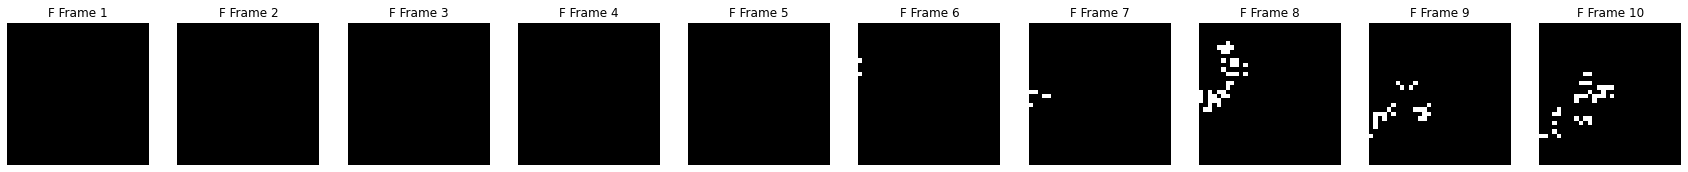

In [36]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(1, 10, figsize=(30, 8))

# Plot the fire frames.
for idx, ax in enumerate(axes):
    ax.imshow(np.squeeze(feature_frames[idx][:,:,:1]), cmap="gray")
    ax.set_title(f"F Frame {idx + 1}")
    ax.axis("off")

# Display the figure.
plt.show()

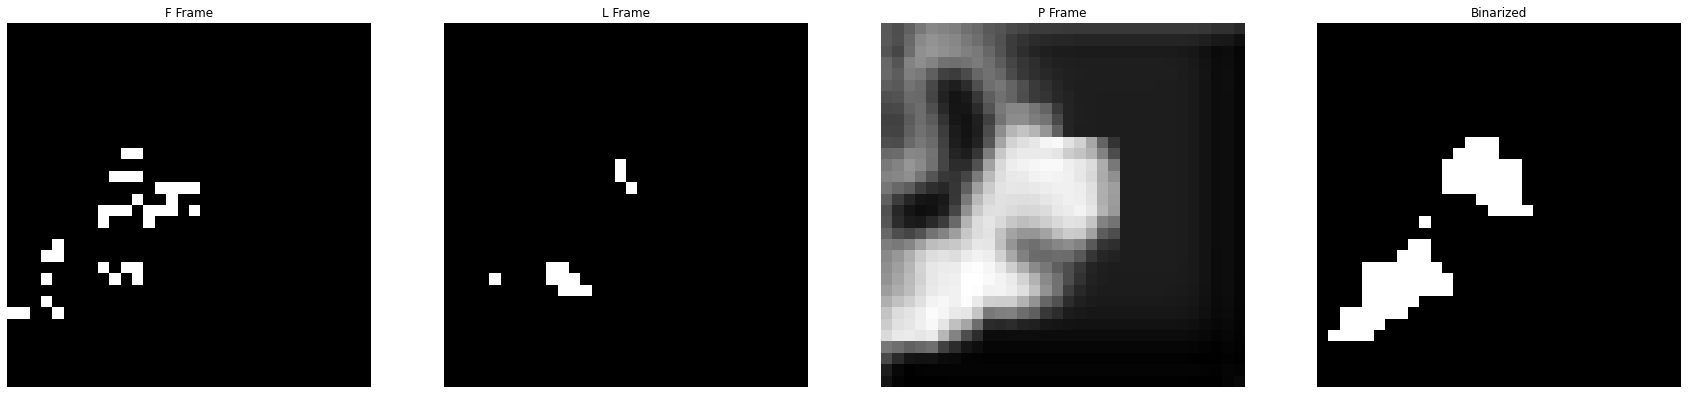

In [40]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(1, 4, figsize=(30, 8))

# Plot the last feature frame.
axes[0].imshow(np.squeeze(feature_frames[9][:,:,:1]), cmap="gray")
axes[0].set_title(f"F Frame")
axes[0].axis("off")

# Plot the label frame.
axes[1].imshow(np.squeeze(label_frames[0]), cmap="gray")
axes[1].set_title(f"L Frame")
axes[1].axis("off")
    
# Plot the predicted frame.
axes[2].imshow(np.squeeze(pred_frames[0]), cmap="gray")
axes[2].set_title(f"P Frame")
axes[2].axis("off")

# Plot binarized prediction.
axes[3].imshow(np.squeeze(np.where(pred_frames > 0.85, 1, 0)), cmap="gray")
axes[3].set_title(f"Binarized")
axes[3].axis("off")

# Display the figure.
plt.show()

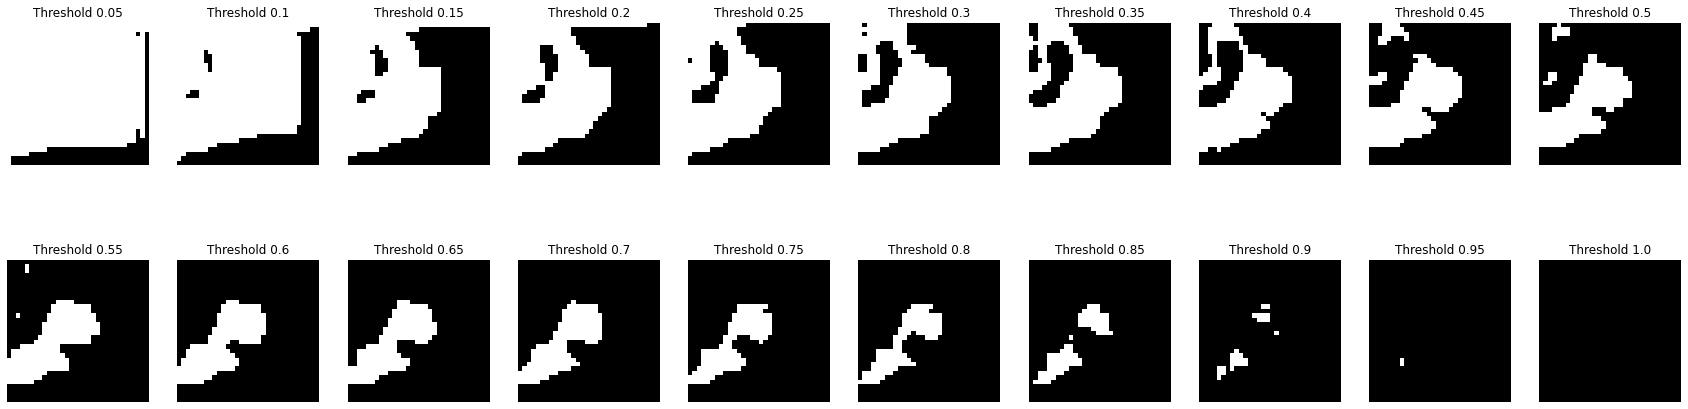

In [38]:
# Construct a figure to show all prediction thresholds.
fig, axes = plt.subplots(2, 10, figsize=(30, 8))

# Plot the frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(np.where(pred_frames > ((idx + 1) * 0.05), 1, 0)), cmap="gray")
    ax.set_title(f"Threshold {round((idx + 1) * 0.05, 2)}")
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(np.where(pred_frames > ((idx + 11) * 0.05), 1, 0)), cmap="gray")
    ax.set_title(f"Threshold {round((idx + 11) * 0.05, 2)}")
    ax.axis("off")
    
# Display the figure.
plt.show()

In [41]:
# Get first sample IoU
thresholds = [x/100 for x in range(0,105,5)]
ious = []
for t in thresholds:
    intersection = np.logical_and(np.where(pred_frames > t, 1, 0), label_frames[0])
    union = np.logical_or(np.where(pred_frames > t, 1, 0), label_frames[0])
    iou_score = np.sum(intersection) / np.sum(union)
    ious.append((t,iou_score))
ious

[(0.0, 0.01171875),
 (0.05, 0.013683010262257697),
 (0.1, 0.016172506738544475),
 (0.15, 0.024489795918367346),
 (0.2, 0.02654867256637168),
 (0.25, 0.029411764705882353),
 (0.3, 0.032),
 (0.35, 0.034482758620689655),
 (0.4, 0.03821656050955414),
 (0.45, 0.04477611940298507),
 (0.5, 0.05106382978723404),
 (0.55, 0.057692307692307696),
 (0.6, 0.06282722513089005),
 (0.65, 0.06779661016949153),
 (0.7, 0.07453416149068323),
 (0.75, 0.08633093525179857),
 (0.8, 0.1),
 (0.85, 0.12941176470588237),
 (0.9, 0.17647058823529413),
 (0.95, 0.0),
 (1.0, 0.0)]

### Get IoU for full prediction set.

In [42]:
# Predict on everything.
all_preds = forecast_model.predict(x_val)

60/60 [==============================] - 6s 91ms/step


In [43]:
# Get IoU.
thresholds = [x/100 for x in range(0,105,5)]
ious = []
for t in thresholds:
    intersection = np.logical_and(np.where(all_preds > t, 1, 0), y_val)
    union = np.logical_or(np.where(all_preds > t, 1, 0), y_val)
    iou_score = np.sum(intersection) / np.sum(union)
    ious.append((t,iou_score))
ious

[(0.0, 0.008262786704784437),
 (0.05, 0.009938744420549312),
 (0.1, 0.01219365552667711),
 (0.15, 0.019483462340704194),
 (0.2, 0.023200774313007617),
 (0.25, 0.028592072227219056),
 (0.3, 0.03272110737654382),
 (0.35, 0.03604788550282007),
 (0.4, 0.03892903567622181),
 (0.45, 0.04167912214881418),
 (0.5, 0.04449443133812476),
 (0.55, 0.04741307205161907),
 (0.6, 0.050544384587848046),
 (0.65, 0.05391324371779742),
 (0.7, 0.05770029942352979),
 (0.75, 0.062338950653875465),
 (0.8, 0.06785028107877322),
 (0.85, 0.07634857840056199),
 (0.9, 0.08399514759401537),
 (0.95, 0.061969056510854846),
 (1.0, 0.0)]

In [44]:
# Get DataFrame of all prediction grades.
rows = []
for s in range(0,len(all_preds)): 
    thresholds = [x/100 for x in range(0,105,5)]
    ious = []
    for t in thresholds:
        intersection = np.logical_and(np.where(all_preds[s] > t, 1, 0), y_val[s])
        union = np.logical_or(np.where(all_preds[s] > t, 1, 0), y_val[s])
        if np.sum(union) > 0:
            iou_score = np.sum(intersection) / np.sum(union)
        else:
            iou_score = 0
        ious.append(iou_score)
    rows.append(ious)
iou_df = pd.DataFrame(rows)

### Examining Good Predictions

In [45]:
iou_df.max()

0     0.131836
1     0.143640
2     0.173175
3     0.179104
4     0.190476
5     0.232258
6     0.244898
7     0.258993
8     0.264706
9     0.276923
10    0.283465
11    0.320000
12    0.388889
13    0.357143
14    0.363636
15    0.379310
16    0.454545
17    1.000000
18    1.000000
19    0.500000
20    0.000000
dtype: float64

In [52]:
iou_df[16].sort_values(ascending = False)

211     0.454545
1447    0.421053
1016    0.411765
817     0.400000
755     0.397959
          ...   
832     0.000000
831     0.000000
830     0.000000
829     0.000000
1901    0.000000
Name: 16, Length: 1902, dtype: float64

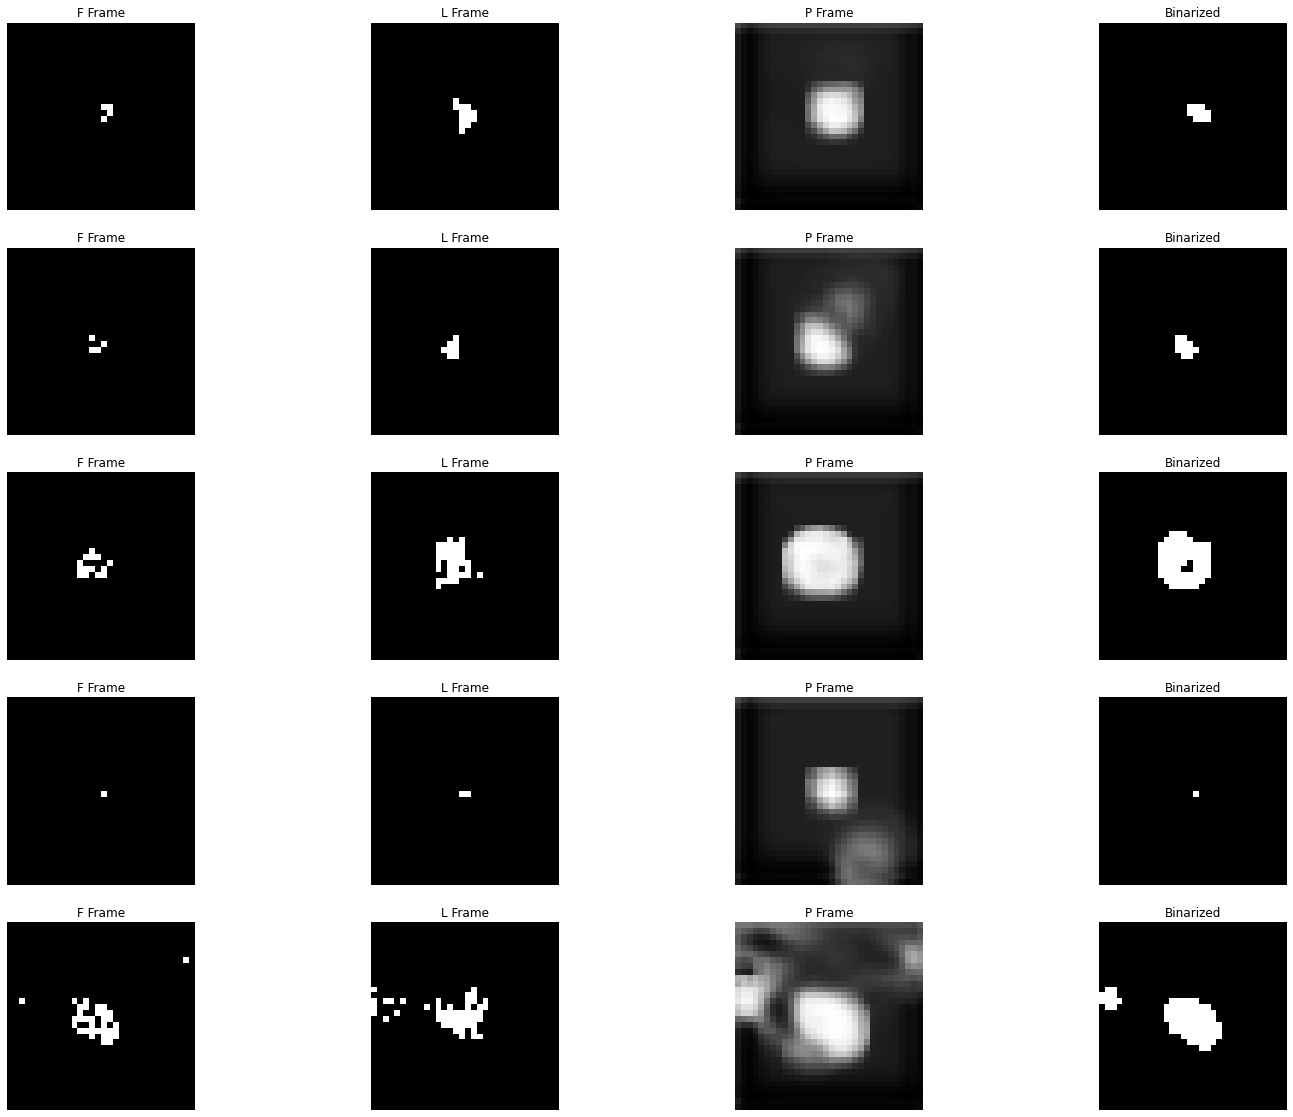

In [55]:
# Construct a figure for the original and new frames.
fig, all_axes = plt.subplots(5, 4, figsize=(25, 20))

# List of samples to check:
tgts = [211, 1447, 1016, 817, 755]
x = -1

for axes in all_axes:
    x += 1
    
    # Plot the last feature frame.
    axes[0].imshow(np.squeeze(x_val[tgts[x]][9][:,:,:1]), cmap="gray")
    axes[0].set_title(f"F Frame")
    axes[0].axis("off")

    # Plot the label frame.
    axes[1].imshow(np.squeeze(y_val[tgts[x]]), cmap="gray")
    axes[1].set_title(f"L Frame")
    axes[1].axis("off")

    # Plot the predicted frame.
    axes[2].imshow(np.squeeze(all_preds[tgts[x]]), cmap="gray")
    axes[2].set_title(f"P Frame")
    axes[2].axis("off")

    # Plot binarized prediction.
    axes[3].imshow(np.squeeze(np.where(all_preds[tgts[x]] > 0.85, 1, 0)), cmap="gray")
    axes[3].set_title(f"Binarized")
    axes[3].axis("off")

# Display the figure.
plt.show()

### Examining Pretty Bad Predictions

In [56]:
iou_df[iou_df[15] > 0.02][15].sort_values()

239     0.020270
1473    0.020408
433     0.020408
359     0.020833
1484    0.021053
          ...   
929     0.359551
608     0.366071
755     0.369369
1016    0.378947
211     0.379310
Name: 15, Length: 865, dtype: float64

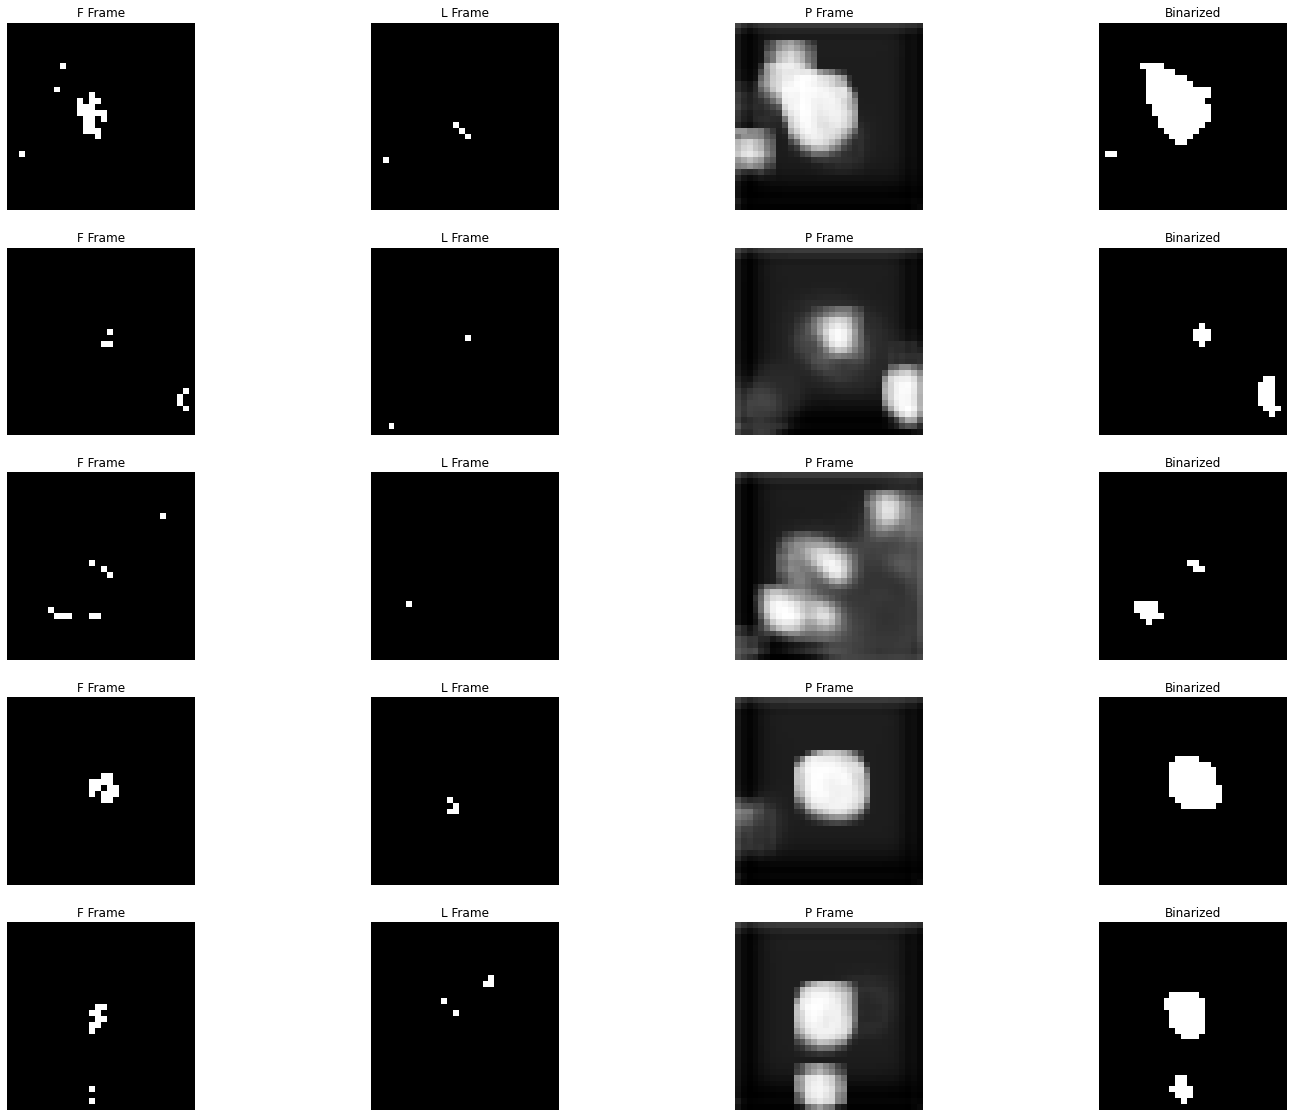

In [57]:
# Construct a figure for the original and new frames.
fig, all_axes = plt.subplots(5, 4, figsize=(25, 20))

# List of samples to check:
tgts = [239, 1473, 433, 359, 1484]
x = -1

for axes in all_axes:
    x += 1
    
    # Plot the last feature frame.
    axes[0].imshow(np.squeeze(x_val[tgts[x]][9][:,:,:1]), cmap="gray")
    axes[0].set_title(f"F Frame")
    axes[0].axis("off")

    # Plot the label frame.
    axes[1].imshow(np.squeeze(y_val[tgts[x]]), cmap="gray")
    axes[1].set_title(f"L Frame")
    axes[1].axis("off")

    # Plot the predicted frame.
    axes[2].imshow(np.squeeze(all_preds[tgts[x]]), cmap="gray")
    axes[2].set_title(f"P Frame")
    axes[2].axis("off")

    # Plot binarized prediction.
    axes[3].imshow(np.squeeze(np.where(all_preds[tgts[x]] > 0.85, 1, 0)), cmap="gray")
    axes[3].set_title(f"Binarized")
    axes[3].axis("off")

# Display the figure.
plt.show()